<a href="https://colab.research.google.com/github/Austfi/SNOWPACKforPatrollers/blob/dev/RF_Instability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RF Snow Instability Analysis - Modern Model

This notebook analyzes SNOWPACK PRO files using the Random Forest instability model from the `sarp.snowprofile.pyface` CRAN package. It automatically selects a version-compatible pickle file based on your installed scikit-learn version.

## Original Model

This implementation is based on the Random Forest snow instability model developed by:
- **Original repository**: [WSL/SLF GitLab - Random Forest Snow Instability Model](https://git.wsl.ch/mayers/random_forest_snow_instability_model.git)
- **Authors**: mayers, fherla (WSL Institute for Snow and Avalanche Research SLF)
- **Original code**: Uses `comp_features()` and `comp_rf_probability()` functions from `pyunstable.py`

This notebook provides a modernized interface with automatic model version selection while maintaining compatibility with the original API and feature calculations.

## Features

- **Automatic model selection**: Downloads and selects the best RF model pickle for your scikit-learn version
- **Single profile analysis**: Analyze a specific timestamp from a PRO file
- **Seasonal evolution**: Track instability probabilities over time
- **CSV export**: Export daily instability metrics for further analysis

## Notes

- `slopeangle` only tunes the MF-crust penetration-depth logic.
- `P_unstable` reports the layer-wise instability probability rather than a direct hazard rating.
- This notebook requires Python helper modules (`readProfile`, `get_RF`, `plt_RF`) that read SNOWPACK PRO files compatible with the [sarp.snowprofile R package](https://cran.r-project.org/web/packages/sarp.snowprofile/refman/sarp.snowprofile.html#snowprofilePro) PRO file format specification.

## Setup

Run the following cells sequentially to set up the environment and load the RF model.


In [ ]:
# Environment setup
import sys, platform, pathlib, datetime
import sklearn, joblib
from packaging import version

print("Python:", sys.version)
print("Platform:", platform.platform())
print("scikit-learn:", sklearn.__version__)

# Setup paths
rf_nb_dir = pathlib.Path.cwd()
rf_mod_dir = (rf_nb_dir / "rf_instability_modern").resolve()
rf_mod_dir.mkdir(parents=True, exist_ok=True)

if str(rf_mod_dir) not in sys.path:
    sys.path.insert(0, str(rf_mod_dir))

print(f"\nRF module directory: {rf_mod_dir}")


Python: 3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 08:28:27) [Clang 14.0.6 ]
Platform: macOS-10.16-x86_64-i386-64bit
scikit-learn: 1.5.1


In [ ]:
# Download and extract RF model files from CRAN tarball
import tarfile, urllib.request, io

rf_inst_py_dir = rf_mod_dir / "inst_python"
rf_inst_py_dir.mkdir(exist_ok=True)

# Check if files already exist
rf_has_sav_files = len(list(rf_inst_py_dir.glob("*.sav"))) > 0
rf_has_py_modules = (rf_mod_dir / "readProfile.py").exists() and (rf_mod_dir / "pyunstable.py").exists()

if rf_has_sav_files and rf_has_py_modules:
    print("✓ Files already present - skipping download")
else:
    print("Downloading CRAN tarball...")
    rf_candidates = ["0.4.3", "0.4.2", "0.4.1", "0.4.0"]
    rf_base_live = "https://cran.r-project.org/src/contrib"
    rf_base_archive = "https://cran.r-project.org/src/contrib/Archive/sarp.snowprofile.pyface"
    rf_downloaded = None

    for rf_ver in rf_candidates:
        rf_urls = [
            f"{rf_base_live}/sarp.snowprofile.pyface_{rf_ver}.tar.gz",
            f"{rf_base_archive}/sarp.snowprofile.pyface_{rf_ver}.tar.gz",
        ]
        for rf_url in rf_urls:
            try:
                with urllib.request.urlopen(rf_url, timeout=30) as rf_response:
                    rf_data = rf_response.read()
                rf_downloaded = (rf_ver, rf_data)
                print("Downloaded:", rf_url)
                break
            except Exception:
                continue
        if rf_downloaded:
            break

    if rf_downloaded:
        rf_ver, rf_data = rf_downloaded
        with tarfile.open(fileobj=io.BytesIO(rf_data), mode="r:gz") as rf_tar:
            # Extract .sav model files
            rf_sav_members = [
                m for m in rf_tar.getmembers()
                if m.name.startswith("sarp.snowprofile.pyface/inst/python/") and m.name.endswith(".sav")
            ]
            if rf_sav_members:
                for rf_member in rf_sav_members:
                    rf_target = rf_inst_py_dir / pathlib.Path(rf_member.name).name
                    with rf_tar.extractfile(rf_member) as rf_source:
                        if rf_source is not None:
                            rf_target.write_bytes(rf_source.read())
                print(f"Extracted {len(rf_sav_members)} .sav files to: {rf_inst_py_dir}")
            
            # Extract Python helper modules
            rf_py_members = [
                m for m in rf_tar.getmembers()
                if m.name.startswith("sarp.snowprofile.pyface/inst/python/") and m.name.endswith(".py")
            ]
            if rf_py_members:
                for rf_member in rf_py_members:
                    rf_filename = pathlib.Path(rf_member.name).name
                    rf_target = rf_mod_dir / rf_filename
                    if not rf_target.exists():
                        with rf_tar.extractfile(rf_member) as rf_source:
                            if rf_source:
                                rf_target.write_bytes(rf_source.read())
                print(f"Extracted {len(rf_py_members)} Python helper modules")
    else:
        print("WARNING: Could not fetch the CRAN tarball. Options:")
        print(f"  - Upload a compatible .sav into: {rf_inst_py_dir}")
        print("  - Or mount Drive and set rf_model_path manually.")


Backup previously detected: SNOWPACKforPAtrollers.backup.20251103-2018.ipynb
RF modern dir: /Users/austinfinnell/Documents/GitHub/SNOWPACKforPatrollers/rf_instability_modern


In [ ]:
# Load RF model (auto-selects best version for your scikit-learn)
def rf_select_model_path(inst_dir: pathlib.Path, skl_ver: str):
    rf_files = sorted(inst_dir.glob("*.sav"))
    if not rf_files:
        return None, "No .sav files present."
    rf_version = version.parse(skl_ver)
    if rf_version >= version.parse("1.5"):
        rf_prefs = ["scikit152", "scikit121", "published_2022"]
    elif rf_version >= version.parse("1.2"):
        rf_prefs = ["scikit121", "scikit152", "published_2022"]
    else:
        rf_prefs = ["published_2022", "scikit121", "scikit152"]
    for rf_key in rf_prefs:
        for rf_file in rf_files:
            if rf_key in rf_file.name:
                return rf_file, None
    return rf_files[-1], "Heuristic fallback: picked the last available .sav"

rf_skl_ver = sklearn.__version__
rf_model_path, rf_model_warning = rf_select_model_path(rf_inst_py_dir, rf_skl_ver)

if rf_model_path is None:
    raise RuntimeError(f"No model file found. Upload a compatible .sav into: {rf_inst_py_dir}")

print("scikit-learn:", rf_skl_ver)
print("Chosen model:", rf_model_path.name)
if rf_model_warning:
    print("Note:", rf_model_warning)

rf_model_modern = joblib.load(rf_model_path)
print("✓ Model loaded successfully")


✓ Files already present - skipping download
  Found .sav files in: /Users/austinfinnell/Documents/GitHub/SNOWPACKforPatrollers/rf_instability_modern/inst_python
  Found Python modules in: /Users/austinfinnell/Documents/GitHub/SNOWPACKforPatrollers/rf_instability_modern


In [ ]:
# Import helper modules
import importlib
import get_RF, readProfile, plt_RF
importlib.reload(plt_RF)  # Reload to pick up any code changes

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("✓ Helper modules imported")


Checking helper modules...
✓ get_RF.py available
✓ readProfile.py available
✓ plt_RF.py available

✓ All helper modules ready!


## Single Profile Analysis

Analyze a specific timestamp from a PRO file.


Reading file:  snowprofiles/WFJ2_2017.pro


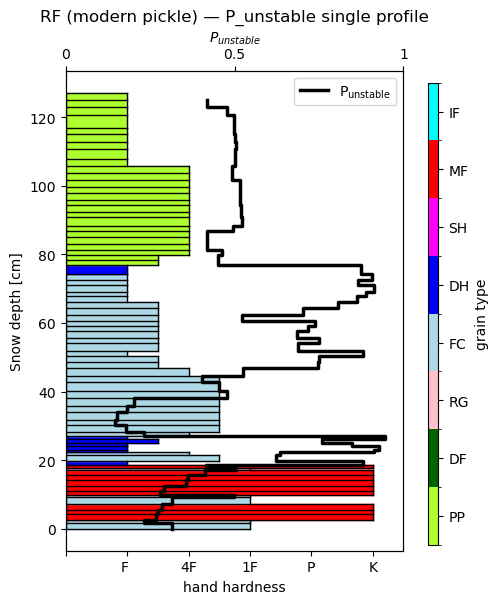

In [ ]:
# Single profile analysis
def rf_fix_punstable(df: pd.DataFrame, column: str = 'P_unstable') -> pd.DataFrame:
    """Ensure instability probabilities sit inside [0, 1], with gentle auto-scaling."""
    if column not in df.columns:
        return df
    rf_vals = pd.to_numeric(df[column], errors='coerce')
    rf_valid = rf_vals.dropna()
    if len(rf_valid) == 0:
        return df
    rf_min, rf_max = float(rf_valid.min()), float(rf_valid.max())
    if rf_max <= 1.0 + 1e-6 and rf_min >= -1e-6:
        df[column] = rf_vals.clip(0.0, 1.0)
    elif rf_max <= 100.0 and rf_min >= 0.0:
        df[column] = (rf_vals / 100.0).clip(0.0, 1.0)
    else:
        df[column] = rf_vals.clip(0.0, 1.0)
    return df

# Find example PRO file
rf_example_pro = None
rf_example_candidates = [
    pathlib.Path("snowprofiles/WFJ2_2017.pro"),
    pathlib.Path("../input_example/WFJ2_2017.pro"),
    pathlib.Path("input_example/WFJ2_2017.pro"),
]
for rf_candidate in rf_example_candidates:
    if rf_candidate.exists():
        rf_example_pro = str(rf_candidate)
        break

if rf_example_pro:
    rf_timestamp = datetime.datetime(2017, 2, 1, 11, 0)
    rf_slopeangle = 0
    
    rf_profile = readProfile.read_profile(rf_example_pro, rf_timestamp, remove_soil=True)
    rf_df_profile = get_RF.create_RFprof(rf_profile, rf_slopeangle, rf_model_modern)
    rf_df_profile = rf_fix_punstable(rf_df_profile)
    
    rf_fig, rf_ax = plt.subplots(figsize=(5, 6))
    plt_RF.plot_sp_single_P0(rf_fig, rf_ax, rf_df_profile, var='P_unstable', colorbar=True)
    rf_ax.set_title("RF — P_unstable single profile")
    plt.show()
else:
    print("No example .pro file found. Set rf_example_pro to your PRO file path.")


## Seasonal Evolution

Track instability probabilities over time for a date range.


In [ ]:
# Seasonal evolution analysis
if rf_example_pro:
    rf_year = 2017
    rf_start = pd.Timestamp(rf_year - 1, 12, 1, 12, 0)
    rf_stop = pd.Timestamp(rf_year, 4, 1, 12, 0)
    rf_slopeangle = 0
    
    rf_profiles_all = readProfile.read_profile(rf_example_pro, remove_soil=True)
    rf_profiles_data = rf_profiles_all.get('data', {}) if isinstance(rf_profiles_all, dict) else {}
    
    rf_dates = pd.date_range(rf_start, rf_stop, freq='D')
    rf_rows = []
    for rf_ts in rf_dates:
        rf_profile_daily = rf_profiles_data.get(rf_ts)
        if rf_profile_daily is None or len(rf_profile_daily.get('height', [])) == 0:
            continue
        rf_df_daily = get_RF.create_RFprof(rf_profile_daily, rf_slopeangle, rf_model_modern)
        rf_df_daily = rf_fix_punstable(rf_df_daily)
        if 'layer_top' in rf_df_daily:
            rf_df_daily['HS'] = rf_df_daily['layer_top'].iloc[-1]
        rf_df_daily.insert(0, 'datetime', rf_ts)
        rf_rows.append(rf_df_daily)
    
    if rf_rows:
        rf_evo = pd.concat(rf_rows, ignore_index=True)
        rf_evo = rf_evo.sort_values(['datetime', 'layer_top']).reset_index(drop=True)
        
        if rf_evo['datetime'].nunique() >= 2:
            rf_fig_evo, rf_ax_evo = plt.subplots(figsize=(7, 4))
            plt_RF.plot_evo_SP(rf_evo, rf_fig_evo, rf_ax_evo, rf_start, rf_stop, 
                              var='P_unstable', colorbar=True, resolution='D')
            rf_ax_evo.set_title("RF — seasonal evolution of P_unstable")
            plt.show()
        else:
            print(f"Need ≥2 daily profiles; found {rf_evo['datetime'].nunique()}. Adjust rf_start/rf_stop.")
    else:
        print("No profiles found between", rf_start, "and", rf_stop)
else:
    print("Set rf_example_pro above to run seasonal evolution.")


## Optional: Custom File Analysis

Use your own PRO file and export results to CSV.


In [ ]:
# Optional: Custom file analysis and CSV export
try:
    from google.colab import drive
    rf_in_colab = True
except Exception:
    rf_in_colab = False

if rf_in_colab:
    drive.mount('/content/drive', force_remount=True)

rf_my_pro_file = ""  # e.g., "/content/drive/MyDrive/SNOWPACK/KEYSTONE_2025.pro"
rf_my_ts = "2025-01-15 11:00"
rf_my_slope = 35
rf_out_csv = (rf_nb_dir / "p_unstable_daily.csv").resolve()

if rf_my_pro_file:
    rf_profiles_custom = readProfile.read_profile(rf_my_pro_file, remove_soil=True)
    rf_profiles_data = rf_profiles_custom.get('data', {}) if isinstance(rf_profiles_custom, dict) else {}
    
    rf_ts = pd.Timestamp(rf_my_ts)
    rf_profile_custom = rf_profiles_data.get(rf_ts)
    if rf_profile_custom is None:
        raise ValueError(f"Timestamp {rf_ts} not found in {rf_my_pro_file}")
    
    rf_df_custom = get_RF.create_RFprof(rf_profile_custom, rf_my_slope, rf_model_modern)
    rf_df_custom = rf_fix_punstable(rf_df_custom)
    
    rf_fig_custom, rf_ax_custom = plt.subplots(figsize=(5, 6))
    plt_RF.plot_sp_single_P0(rf_fig_custom, rf_ax_custom, rf_df_custom, var='P_unstable', colorbar=True)
    rf_ax_custom.set_title(f"RF — {pathlib.Path(rf_my_pro_file).stem} @ {rf_ts}")
    plt.show()

    # Export daily CSV
    rf_start_custom = pd.Timestamp(rf_ts.year - 1, 12, 1, 12, 0)
    rf_stop_custom = pd.Timestamp(rf_ts.year, 4, 1, 12, 0)
    rf_rows_custom = []
    for rf_day in pd.date_range(rf_start_custom, rf_stop_custom, freq='D'):
        rf_profile_day = rf_profiles_data.get(rf_day)
        if not rf_profile_day or len(rf_profile_day.get('height', [])) == 0:
            continue
        rf_df_day = get_RF.create_RFprof(rf_profile_day, rf_my_slope, rf_model_modern)
        rf_df_day = rf_fix_punstable(rf_df_day)
        rf_rows_custom.append({
            'datetime': rf_day,
            'HS': float(rf_df_day['layer_top'].iloc[-1]) if 'layer_top' in rf_df_day else float('nan'),
            'P_unstable_max': float(rf_df_day['P_unstable'].max()),
            'z_Pmax': float(rf_df_day.loc[rf_df_day['P_unstable'].idxmax(), 'layer_top']) if 'layer_top' in rf_df_day else float('nan')
        })
    
    if rf_rows_custom:
        rf_out_df = pd.DataFrame(rf_rows_custom).sort_values('datetime')
        rf_out_df.to_csv(rf_out_csv, index=False)
        from IPython.display import display
        display(rf_out_df.head())
        print("Wrote:", rf_out_csv)
    else:
        print("No daily profiles found for export between", rf_start_custom, "and", rf_stop_custom)
else:
    print("To analyze your own file, set rf_my_pro_file above and re-run.")


## Notes

- If unpickling fails, upload another `.sav` from the CRAN `inst/python` folder into `rf_instability_modern/inst_python`, or temporarily pin scikit-learn to a version that matches the available filenames.
- `P_unstable` indicates layer-wise instability probability; combine it with field observations before acting on results.
- `slopeangle` only steers the MF-crust penetration-depth heuristic and does not change the underlying trained model.
